In [10]:
import json
import logging
import os
import sys
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyarrow.parquet as pq
import seaborn as sns
import textalloc as ta
from IPython.display import display
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, precision_score, r2_score, recall_score
from tqdm import tqdm

NOTEBOOK_PATH: Path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
PROJECT_DIR: Path = NOTEBOOK_PATH.parent.parent
sys.path.append(str(PROJECT_DIR))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src._StandardNames import StandardNames
from src.evaluate._Data import Data
from src.load.LoadForClassification import RENAMER, LoadForClassification
from src.utils.PathChecker import PathChecker
from src.utils.set_rcparams import set_rcparams

os.chdir(PROJECT_DIR)
set_rcparams()

LOG: logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Log start, project directory is %s (exist: %s)", PROJECT_DIR, PROJECT_DIR.is_dir())

CHECK: PathChecker = PathChecker()
STR: StandardNames = StandardNames()

FIG_DIR: Path = CHECK.check_directory(PROJECT_DIR / "reports" / "figures", exit=False)
FIG_DIR /= NOTEBOOK_PATH.stem
FIG_DIR.mkdir(parents=True, exist_ok=True)
LOG.info("Figure directory is %s (exist: %s)", FIG_DIR, FIG_DIR.is_dir())

DATA_DIR: Path = CHECK.check_directory(PROJECT_DIR / "data" / "doe" / "doe_sobol_20240705_194200", exit=False)
INJ_FPATH: Path = CHECK.check_file(DATA_DIR / STR.fname_injury_crit, exit=False)
CLASSES_FPATHS: Dict[int, Path] = {
    i: CHECK.check_file(DATA_DIR / f"{INJ_FPATH.stem}_classes_{i}.parquet", exit=False) for i in (2, 3, 5, 7)
}
CHANNELS_FPATH: Path = CHECK.check_file(DATA_DIR / STR.fname_channels, exit=False)
J_PATH: Path = CHECK.check_file(DATA_DIR / STR.fname_dropped_ids, exit=False)

2024-12-19 16:33:55,859     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-12-19 16:33:55,900     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle
2024-12-19 16:33:55,921     INFO  MainProcess  MainThread Log start, project directory is /root/py_projects/aihiii (exist: True)
2024-12-19 16:33:55,923     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/reports/figures' exists
2024-12-19 16:33:55,924     INFO  MainProcess  MainThread Figure directory is /root/py_projects/aihiii/reports/figures/baseline (exist: True)
2024-12-19 16:33:55,926     INFO  MainProcess  MainThread Directory '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200' exists
2024-12-19 16:33:55,927     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_194200/injury_criteria.parquet' exists
2024-12-19 16:33:55,929     INFO  MainProcess  MainThread File '/root/py_projects/aihiii/data/doe/doe_sobol_20240705_1

In [2]:
with open(J_PATH) as f:
    DROPPED_IDS = {int(k):set(i) for k,i in json.load(f).items()}
DROPPED_IDS

{5: {68,
  102,
  600,
  1388,
  3673,
  3687,
  3848,
  4720,
  5100,
  5665,
  5733,
  5739,
  6320,
  6802,
  7533},
 50: {926, 1020},
 95: {2063, 2206, 2229}}

In [3]:
def eval_inj(perc):
    db = (
        pd.read_parquet(
            INJ_FPATH,
            filters=[("PERC", "==", perc), ("ID", "not in", DROPPED_IDS[perc])],
            columns=[
                "Head_HIC15",
                "Head_a3ms",
                "Neck_My_Extension",
                "Neck_Fz_Max_Tension",
                "Neck_Fx_Shear_Max",
                "Chest_Deflection",
                "Femur_Fz_Max_Compression",
                "Chest_VC",
                "Chest_a3ms",
            ],
        )
        .droplevel("PERC")
        .astype(np.float32)
    )
    db_med_ = db.median(axis=0)
    db_med = ((db.copy() * 0) + 1) * db_med_

    sc = pd.Series(r2_score(db, db_med, multioutput="raw_values"), index=db.columns)
    display(pd.DataFrame({"Value":db_med_, "R2":sc}))


eval_inj(5)

,Value,R2
Head_HIC15,251.233200,-0.055208
Head_a3ms,54.570988,-0.003805
Neck_My_Extension,23.067635,-0.003454
Neck_Fz_Max_Tension,1.075870,-0.099241
Neck_Fx_Shear_Max,0.789204,-0.100102
Chest_Deflection,27.139257,-0.034763
Femur_Fz_Max_Compression,0.789836,-0.000021
Chest_VC,0.182982,-0.011797
Chest_a3ms,52.877613,-0.000790


In [4]:
eval_inj(95)

,Value,R2
Head_HIC15,342.841949,-0.198494
Head_a3ms,63.264713,-0.220750
Neck_My_Extension,17.180223,-0.114186
Neck_Fz_Max_Tension,1.624609,-0.067442
Neck_Fx_Shear_Max,0.932927,-0.065808
Chest_Deflection,52.430717,-0.005058
Femur_Fz_Max_Compression,6.045951,-0.034575
Chest_VC,0.429752,-0.045297
Chest_a3ms,48.535988,-0.000115


In [5]:
def eval_class(displ=True):
    rel_cols = [
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Extension",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Chest_VC",
        "Femur_Fz_Max_Compression",
    ]
    n_classess = (2, 3, 5, 7)
    db = defaultdict(dict)
    for n_classes in n_classess:
        for perc in [5, 95]:
            db_ = (
                pd.read_parquet(
                    CLASSES_FPATHS[n_classes],
                    filters=[("PERC", "==", perc), ("ID", "not in", DROPPED_IDS[perc])],
                    columns=rel_cols,
                )
                .droplevel("PERC")
                .astype(np.int32)[rel_cols]
            )

            clf = DummyClassifier(strategy="most_frequent")
            clf.fit(db_[rel_cols], db_[rel_cols])
            y_pred = pd.DataFrame(clf.predict(db_), index=db_.index, columns=rel_cols)

            modes = [clf.classes_[i][np.argmax(clf.class_prior_[i])] for i in range(len(clf.classes_))]

            db[n_classes][perc] = pd.DataFrame(
                {
                    "Mode": modes,
                    "Frequency": [np.max(x) for x in clf.class_prior_],
                    "F1": [
                        f1_score(
                            db_[c],
                            y_pred[c],
                            average="weighted",
                            labels=list(range(n_classes)),
                            zero_division=0.0,
                        )
                        for c in rel_cols
                    ],
                },
                index=rel_cols,
            )

            if displ:
                print(n_classes, perc)
                display(db[n_classes][perc].loc[rel_cols])

    if not displ:
        for idx in rel_cols:
            print("#" * 5, idx, "#" * 5)
            for n_classes in n_classess:
                full_str = f"{n_classes:1d}"
                for perc in [5, 95]:
                    full_str += " & "
                    full_str += " & ".join(
                        [str(int(x)) if i == 0 else f"{np.floor(x*100)/100:.2f}" for i, x in enumerate(db[n_classes][perc].loc[idx].values)]
                    )

                print(full_str)


eval_class(displ=False)

##### Head_HIC15 #####
2 & 1 & 0.93 & 0.89 & 1 & 0.74 & 0.63
3 & 2 & 0.73 & 0.62 & 2 & 0.64 & 0.50
5 & 4 & 0.63 & 0.49 & 4 & 0.51 & 0.34
7 & 6 & 0.63 & 0.49 & 6 & 0.51 & 0.34
##### Head_a3ms #####
2 & 1 & 0.97 & 0.96 & 1 & 0.67 & 0.54
3 & 1 & 0.64 & 0.49 & 2 & 0.60 & 0.45
5 & 3 & 0.53 & 0.37 & 4 & 0.32 & 0.15
7 & 5 & 0.53 & 0.37 & 6 & 0.32 & 0.15
##### Neck_My_Extension #####
2 & 1 & 0.99 & 0.99 & 1 & 0.98 & 0.97
3 & 2 & 0.70 & 0.58 & 2 & 0.87 & 0.82
5 & 3 & 0.58 & 0.42 & 4 & 0.73 & 0.61
7 & 5 & 0.58 & 0.42 & 6 & 0.73 & 0.61
##### Neck_Fz_Max_Tension #####
2 & 1 & 0.97 & 0.96 & 1 & 0.97 & 0.96
3 & 2 & 0.70 & 0.58 & 2 & 0.96 & 0.95
5 & 3 & 0.50 & 0.34 & 4 & 0.90 & 0.85
7 & 5 & 0.50 & 0.34 & 6 & 0.90 & 0.85
##### Neck_Fx_Shear_Max #####
2 & 1 & 0.88 & 0.83 & 1 & 0.99 & 0.99
3 & 2 & 0.61 & 0.46 & 2 & 0.95 & 0.93
5 & 3 & 0.47 & 0.30 & 4 & 0.91 & 0.88
7 & 5 & 0.47 & 0.30 & 6 & 0.91 & 0.88
##### Chest_Deflection #####
2 & 0 & 0.97 & 0.96 & 0 & 0.55 & 0.40
3 & 0 & 0.97 & 0.96 & 1 & 0.67 & 0.5

In [6]:
def eval_class_conf(n_classes: int, perc: int, col: str):
    rel_cols = [
        "Head_HIC15",
        "Head_a3ms",
        "Neck_My_Extension",
        "Neck_Fz_Max_Tension",
        "Neck_Fx_Shear_Max",
        "Chest_Deflection",
        "Chest_VC",
        "Femur_Fz_Max_Compression",
    ]

    db_ = (
        pd.read_parquet(
            CLASSES_FPATHS[n_classes],
            filters=[("PERC", "==", perc), ("ID", "not in", DROPPED_IDS[perc])],
            columns=[col],
        )
        .droplevel("PERC")
        .astype(np.int32)
    )

    clf = DummyClassifier(strategy="most_frequent")
    clf.fit(db_, db_)
    y_pred = pd.DataFrame(clf.predict(db_), index=db_.index, columns=[col])
    print(clf.classes_)

    conf = confusion_matrix(db_[col], y_pred[col], labels=list(range(n_classes)))
    conf = pd.DataFrame(
        conf,
        index=[f"True {x}" for x in range(n_classes)],
        columns=[f"Pred {x}" for x in range(n_classes)],
    )
    display(conf)


eval_class_conf(n_classes=3, perc=5, col="Femur_Fz_Max_Compression")

[1 2]


,Pred 0,Pred 1,Pred 2
True 0,0,0,0
True 1,0,0,1
True 2,0,0,8176


8177
8177


2024-12-19 21:15:55,419     INFO  MainProcess  MainThread maxp pruned
2024-12-19 21:15:55,422     INFO  MainProcess  MainThread cmap pruned
2024-12-19 21:15:55,423     INFO  MainProcess  MainThread post pruned
2024-12-19 21:15:55,424     INFO  MainProcess  MainThread FFTM dropped
2024-12-19 21:15:55,426     INFO  MainProcess  MainThread GPOS pruned
2024-12-19 21:15:55,427     INFO  MainProcess  MainThread GSUB pruned
2024-12-19 21:15:55,431     INFO  MainProcess  MainThread glyf pruned
2024-12-19 21:15:55,433     INFO  MainProcess  MainThread Added gid0 to subset
2024-12-19 21:15:55,433     INFO  MainProcess  MainThread Added first four glyphs to subset
2024-12-19 21:15:55,434     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 20 glyphs before
2024-12-19 21:15:55,434     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'H', 'K', 'M', 'N', 'O', 'P', 'R', 'U', 'Y', 'five', 'glyph1', 'space', 'three', 'uni000D', 'zero']
2024-12-19 21:15:55,436     

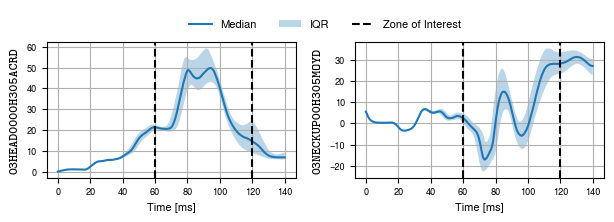

In [120]:
def conv_intervals(chs, perc: int):
    f_width = 448.13095 / 72 - 0.2
    fig, ax = plt.subplot_mosaic(mosaic=[["L"]*len(chs), chs], layout="constrained", height_ratios=[0.1,1])

    for i, ch in enumerate(chs):
        db = pd.read_parquet(
            CHANNELS_FPATH,
            columns=[ch],
            filters=[("PERC", "==", perc), ("ID", "not in", DROPPED_IDS[perc])],
        ).droplevel("PERC")
        print(len(set(db.index.get_level_values(STR.id))))
        db = db.groupby("TIME").quantile([0.25, 0.5, 0.75])
        db.index.set_names(["TIME", "Quantile"], inplace=True)
        db = db[ch].unstack("Quantile")

        ax[ch].plot(db.index, db[0.5], label="Median")
        ax[ch].fill_between(db.index, db[0.25], db[0.75], alpha=0.3, label="IQR")
        ax[ch].grid()
        [ax[ch].axvline(v, c="black", ls="--", label="Zone of Interest" if v==60 else "") for v in (60, 120)]
        ax[ch].set_xlabel("Time [ms]")
        ax[ch].set_ylabel(ch.replace("OCCU", f"H3{perc:02d}"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
    ax["L"].legend(*ax[chs[0]].get_legend_handles_labels(), loc="upper center", ncols=3)
    ax["L"].axis("off")

    fig.set_figheight(0.35 * f_width)
    fig.set_figwidth(f_width)
    fig.savefig(FIG_DIR / f"intervals_{perc}.pdf")


conv_intervals(chs=["03HEAD0000OCCUACRD", "03NECKUP00OCCUMOYD"], perc=5)

In [114]:
def eval_channel(perc:int):
        db = pd.read_parquet(
            CHANNELS_FPATH,
            # columns=[ch],
            filters=[("PERC", "==", perc), ("ID", "not in", DROPPED_IDS[perc])],
        ).droplevel("PERC")

2024-12-19 21:00:40,184     INFO  MainProcess  MainThread Read data from data/doe/doe_sobol_20240705_194200/channels.parquet
2024-12-19 21:00:40,416     INFO  MainProcess  MainThread Got data of shape (1401, 2) and size 0.057MB
2024-12-19 21:00:40,419     INFO  MainProcess  MainThread Got data temporal None and tabular None
2024-12-19 21:00:40,427     INFO  MainProcess  MainThread Got data temporal (1401, 2) and tabular None
2024-12-19 21:00:40,486     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 1400
2024-12-19 21:00:40,500     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 70
2024-12-19 21:00:40,510     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 28
2024-12-19 21:00:40,522     INFO  MainProcess  MainThread Downsample temporal data from 1401 to 10
2024-12-19 21:00:40,934     INFO  MainProcess  MainThread maxp pruned
2024-12-19 21:00:40,938     INFO  MainProcess  MainThread cmap pruned
2024-12-19 21:00:40,939     INFO 

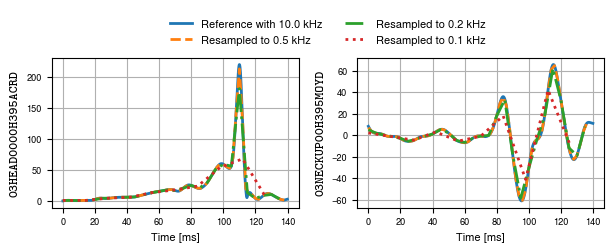

In [116]:
def plot_resampler(chs: List[str], perc: int, n_stps: List[int], sid: int):
    f_path = Path("data") / "doe" / "doe_sobol_20240705_194200" / "channels.parquet"
    a = Data()
    a.set_from_files(file_paths=[f_path], percentiles=[perc], idxs=[sid], columns=chs)

    f_width = 448.13095 / 72 - 0.2
    fig, ax = plt.subplot_mosaic(mosaic=([["L"] * len(chs), chs]), layout="constrained", height_ratios=[0.1, 1])
    ls = ["-", "--", "-.", ":"]

    for j, n_tsp in enumerate(reversed(n_stps)):
        db: pd.DataFrame = a.get_temporal_resampled(n_tsp)
        for i, ch in enumerate(chs):
            ax[ch].plot(
                db.index.get_level_values(STR.time),
                db[ch],  # - 10 * j,
                label=f"{'Reference with' if n_tsp == 1400 else 'Resampled to'} {n_tsp/140:.1f} kHz",
                # marker="o",
                # markersize=1,
                # alpha=0.5,
                linewidth=2,
                ls=ls[j]
            )

            if j == 0:
                ax[ch].set_xlabel("Time [ms]")
                ax[ch].set_ylabel(ch.replace("OCCU", f"H3{perc:02d}"), {"fontname": "CMU Typewriter Text", "fontsize": "large", "fontweight": "bold"})
                ax[ch].grid()
    ax["L"].legend(*ax[chs[0]].get_legend_handles_labels(), ncol=2, loc="upper center")
    ax["L"].axis("off")

    fig.set_figheight(0.4 * f_width)
    fig.set_figwidth(f_width)
    fig.savefig(FIG_DIR / f"resampling_{perc}.pdf")


plot_resampler(chs=["03HEAD0000OCCUACRD", "03NECKUP00OCCUMOYD"], perc=95, n_stps=[10, 28, 70, 1400], sid=66)